### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [3]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here
data.isna().sum().sort_values(ascending=False).head()

passenger_count    145864
distance_km        145864
hour_19                 0
hour_11                 0
hour_12                 0
dtype: int64

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [4]:
data['passenger_count'].value_counts(ascending=False).index[0]

930.3997532751514

In [5]:
### Your code is here
data['passenger_count'] = data['passenger_count'].fillna(data['passenger_count'].value_counts().index[0])

In [6]:
data.isna().sum().sort_values().head()

vendor_id    0
hour_10      0
hour_11      0
hour_12      0
hour_13      0
dtype: int64

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [7]:
### Your code is here
group = ['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6']
grouped_means = data.groupby(group)['distance_km'].transform("mean")
data['distance_km'] = data['distance_km'].fillna(grouped_means)

In [8]:
### Убедимся, что пропусков не осталось

### Your code is here
data.isna().any().any()

False

In [9]:
data.head(20).to_csv('task_7.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [10]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
X = data.drop('log_trip_duration', axis=1)
Y = data['log_trip_duration']
cv = cross_validate(LinearRegression(), X, Y, cv=selector, scoring='neg_mean_squared_error')
print(f"MSLE на Кросс-валидации: {round(-cv['test_score'].mean(), 3)}")

MSLE на Кросс-валидации: 0.431


In [11]:
cv

{'fit_time': array([2.53646207, 2.52878189, 2.58761978, 2.52268982]),
 'score_time': array([0.31749129, 0.29144645, 0.29247284, 0.28850222]),
 'test_score': array([-0.45104813, -0.44555323, -0.40741744, -0.41963126])}

### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

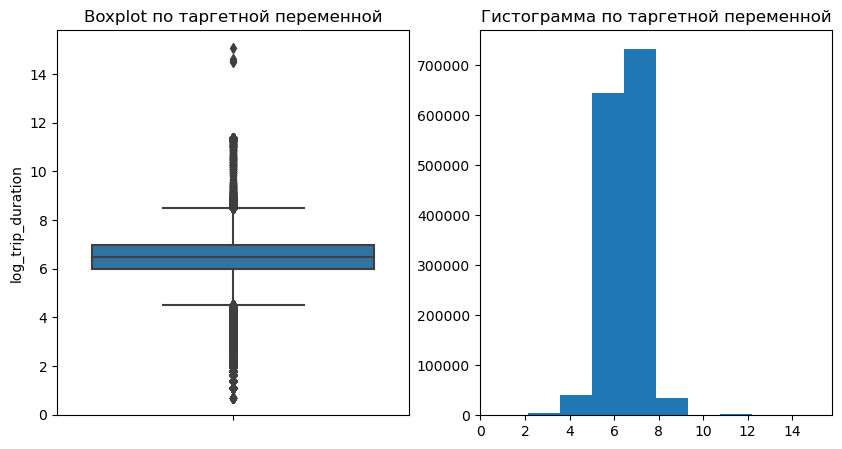

In [12]:
### Your code is here
def draw_plots():
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure()
    fig.set_size_inches(10, 5)

    ax_1 = fig.add_subplot(1, 2, 1)
    sns.boxplot(y='log_trip_duration', data=data)

    ax_2 = fig.add_subplot(1, 2, 2)
    plt.hist(x='log_trip_duration', data=data)

    ax_1.set(title='Boxplot по таргетной переменной')
    ax_2.set(title='Гистограмма по таргетной переменной')

    plt.show()

draw_plots()

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [13]:
### Your code is here
q_low = data['log_trip_duration'].quantile(0.005)
q_high = data['log_trip_duration'].quantile(0.995)

In [14]:
q_low, q_high

(3.9318256327243257, 8.32845106681936)

In [15]:
data = data[(data['log_trip_duration']<q_high) & (data['log_trip_duration']>q_low)]

In [16]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Проверил, как теперь выглядят графики

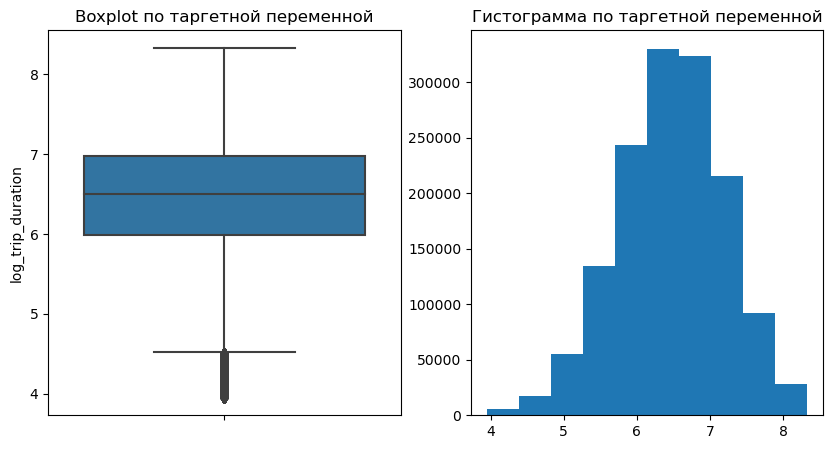

In [17]:
draw_plots()

Снова замерьте качество на кросс-валидации, используя старый selector

In [18]:
X = data.drop('log_trip_duration', axis=1)
Y = data['log_trip_duration']
cv = cross_validate(LinearRegression(), X, Y, cv=selector, scoring='neg_mean_squared_error')
print(f"MSLE на Кросс-валидации: {round(-cv['test_score'].mean(), 3)}")

MSLE на Кросс-валидации: 0.35
